In [5]:
# Import necessary libraries
import pandas as pd

# Define selected features and target variable
selected_features = ['T (K)', 'P (MPa)', 'methane', 'ethane', 'propane',
                     'ibutane', 'ipentane', 'hexane', 'heptane', 'helium',
                     'oxygen', 'H2S', 'CO2']
target_variable = 'z'

# Load the dataset
data = pd.read_csv('cleaneded_main_model_data.csv')

# Extract selected features and target variable
X = data[selected_features]
y = data[target_variable]


In [6]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
from sklearn.svm import NuSVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

# Initialize base models
model_NuSVR = NuSVR()
model_GPR = GaussianProcessRegressor()
model_AdaBoost = AdaBoostRegressor()
model_SGDBoost = GradientBoostingRegressor()
model_WKNN = KNeighborsRegressor()

# Create a list of base models for blending
def get_models():
    models = []
    models.append(('NuSVR', model_NuSVR))
    models.append(('GPR', model_GPR))
    models.append(('AdaBoost', model_AdaBoost))
    models.append(('SGDBoost', model_SGDBoost))
    models.append(('WKNN', model_WKNN))
    return models


In [8]:
# Fit the base models on the training data
def fit_base_models(models, X_train, y_train):
    for name, model in models:
        model.fit(X_train, y_train)

# Get the list of base models
models = get_models()

# Fit the base models on the training data
fit_base_models(models, X_train, y_train)


In [9]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from numpy import hstack

# Fit the blending ensemble
def fit_ensemble(models, X_train, y_train):
    # Make predictions on the training data for blending
    meta_X = []
    for name, model in models:
        yhat = model.predict(X_train)
        yhat = yhat.reshape(len(yhat), 1)
        meta_X.append(yhat)
    
    # Create 2D array from predictions as input features for blending
    meta_X = hstack(meta_X)
    
    # Define and fit the blending model (e.g., Linear Regression)
    blender = LinearRegression()
    blender.fit(meta_X, y_train)
    return blender

# Train the blending ensemble
blender = fit_ensemble(models, X_train, y_train)


In [10]:
# Make predictions with the blending ensemble
def predict_ensemble(models, blender, X_test):
    # Make predictions with base models on the test data
    meta_X = []
    for name, model in models:
        yhat = model.predict(X_test)
        yhat = yhat.reshape(len(yhat), 1)
        meta_X.append(yhat)
    
    # Create 2D array from predictions for the test data
    meta_X = hstack(meta_X)
    
    # Predict using the blending model
    return blender.predict(meta_X)

# Make predictions on the test data using the blending ensemble
blended_predictions = predict_ensemble(models, blender, X_test)


In [11]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Evaluate performance metrics (R-squared, MSE, MAE) for the blended predictions
r2 = r2_score(y_test, blended_predictions)
mse = mean_squared_error(y_test, blended_predictions)
mae = mean_absolute_error(y_test, blended_predictions)

print(f"R-squared: {r2:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")


R-squared: -11233.582
Mean Squared Error (MSE): 0.013
Mean Absolute Error (MAE): 0.031


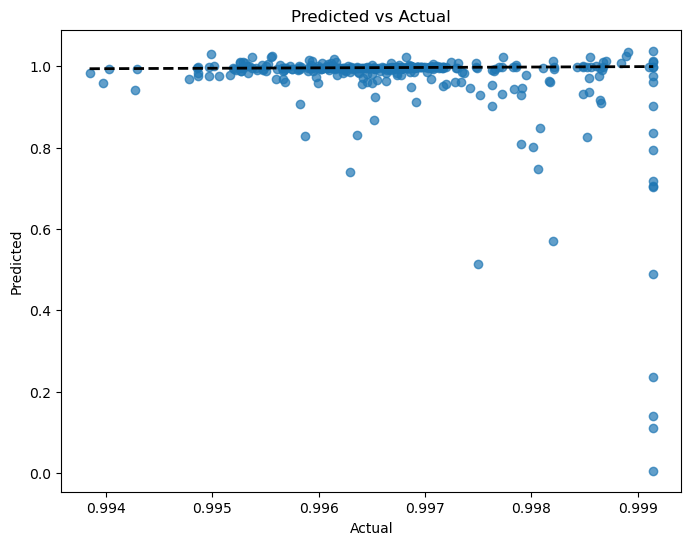

In [12]:
import matplotlib.pyplot as plt

# Plotting predicted vs. actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, blended_predictions, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR

# Define parameters for SVR
param_grid_svr = {
    'C': [1, 10, 100],
    'gamma': [0.1, 1, 10],
    'kernel': ['rbf', 'linear', 'poly']
}

# Initialize SVR model
svr = NuSVR()

# Perform GridSearchCV for SVR
grid_svr = GridSearchCV(svr, param_grid_svr, cv=5, scoring='r2')
grid_svr.fit(X_train, y_train)

# Get the best SVR model
best_svr = grid_svr.best_estimator_


In [ ]:
# Retrain the best models on the entire training data
best_svr.fit(X_train, y_train)
# Repeat for other best models


In [ ]:
# Update the base models list with the best-tuned models
models = get_models()  # Assuming get_models() returns the base models
# Replace the corresponding models with the best-tuned models
# For example, replace SVR with the best-tuned SVR model
for i, (name, model) in enumerate(models):
    if name == 'SVR':
        models[i] = ('SVR', best_svr)
    # Repeat for other best-tuned models


In [ ]:
# Refit the ensemble with updated models
blender = fit_ensemble(models, X_train, y_train)

# Make predictions on the test data using the updated ensemble
blended_predictions = predict_ensemble(models, blender, X_test)
